In [71]:
from qutip import *
import math as math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy as scipy
import matplotlib.animation as animation
from tqdm import tqdm

Parámetros del sistema

In [72]:
w_0 = 1 # Frecuencia natural x>0
W_0 = 5 # Frecuencia natural x<0
amort = 0 # constante de amortiguamiento
f_0 = 0 # Amplitud de la fuerza por unidad de masa
m = 1 # masa del oscilador
N = 50 # Numero de fonones

Frecuencia natural del oscilador

In [73]:
def W(x): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

Desarrollo del potencial en la base de autoestados del oscilador armónico cuántico

In [74]:
def U(x):
    return 0.5*m*x**2*W(x)**2

In [75]:
def autoest(n,x,conj): # autoestados del oscilador armónico cuántico
    pol_Herm = scipy.special.hermite(n)
    xi = np.sqrt(m*w_0)*x
    phi = (m*w_0/(np.pi))**(0.25)*(1/math.sqrt(2**n*np.math.factorial(n)))*pol_Herm(xi)*np.exp(-(xi**2)/2)
    if conj == True:
        return np.conj(phi)
    return phi

In [76]:
x = np.linspace(-10,10,500) # Estas x tienen unidades de posición
Unm = np.zeros([N,N],dtype=complex)
U_x = np.zeros(np.size(x),dtype=complex)

for i in tqdm(range(N)):
    for j in range(N):
        Unm[i][j] = scipy.integrate.simpson(autoest(j,x,False)*autoest(i,x,True)*U(x),x)
        U_x = U_x + autoest(j,x,False)*autoest(i,x,True)*Unm[i][j]

U_q = Qobj(Unm)


100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


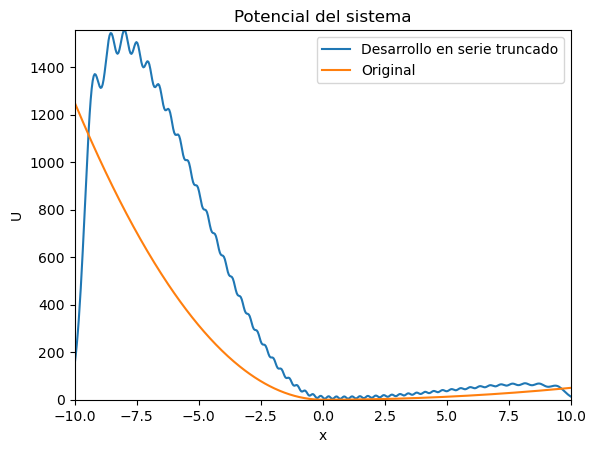

In [77]:
plt.plot(x,U_x,label='Desarrollo en serie truncado')
plt.plot(x,U(x),label='Original')
plt.xlim([-10,10])
plt.ylim([0,np.max(U_x)])
plt.title('Potencial del sistema')
plt.xlabel('x')
plt.ylabel('U')
plt.legend()
plt.show()

Simulación de la dinámica cuántica

In [78]:
dt = 0.2 # Paso de tiempo
tf = 30 # Tiempo de medida (se asume que t0 = 0)
tvec = np.linspace(0,tf,int(tf/dt)+1) # Vector de instantes de tiempo

In [79]:
def check_state(psi):
    check = []
    for i in range(np.size(psi)):
        if psi[i] == 0:
            check.append(True)
        else:
            check.append(False)

    if all(check[-5:]) == True:
        return 'Psi0 check'
    else:
        return 'Warning'

In [80]:
# Estado inicial:
psi0 = coherent(N,math.sqrt(0.5))
x_0 = expect(position(N),psi0)/math.sqrt(w_0*m) 
p_0 = expect(momentum(N),psi0)*math.sqrt(w_0*m)
print(check_state(psi0)) # Chequeo del estado inicial

# Estado para comparar:
# psi02 = coherent(N,math.sqrt(0.6))

Psi0 check


In [81]:
H = w_0*momentum(N)**2/2+U_q
options = Options(store_states=True,nsteps=5000)
result = sesolve(H, psi0, tvec, [position(N)/math.sqrt(w_0*m),momentum(N)*math.sqrt(w_0*m),U_q],options=options)
# result2 = sesolve(H, psi02, tvec, [position(N)/math.sqrt(w_0*m),momentum(N)*math.sqrt(w_0*m),U_q],options=options)

In [82]:
O = []
# O2 = []
for i in tqdm(range(np.size(tvec))): 
    psi = result.states[i]
    O.append(psi.overlap(psi0))
    # psi2 = result2.states[i]
    # O2.append(psi2.overlap(psi02))

100%|██████████| 151/151 [00:00<00:00, 11128.41it/s]


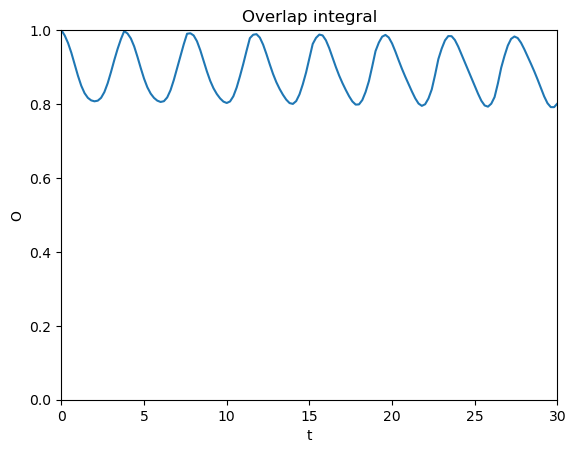

In [83]:
plt.plot(tvec,np.abs(O))
plt.xlim([0,tf])
plt.ylim([0,1])
plt.title('Overlap integral')
plt.xlabel('t')
plt.ylabel('O')
plt.show()


Comparación con caso clásico

In [84]:
def EDO(t,y,w):
    x,v = y
    return [v,-2*amort*v-W(x)**2*x+f_0*np.cos(w*t)]

In [85]:
pos = []
vel = []
w = [1] # frecuencia de la fuerza externa

for i in tqdm(range(np.size(w))):
    sol = scipy.integrate.solve_ivp(EDO, [0,tf], [x_0,p_0], method = 'DOP853',t_eval = tvec,args = [w[i]])
    xc,vc = sol.y
    pos.append(xc)
    vel.append(vc)

100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


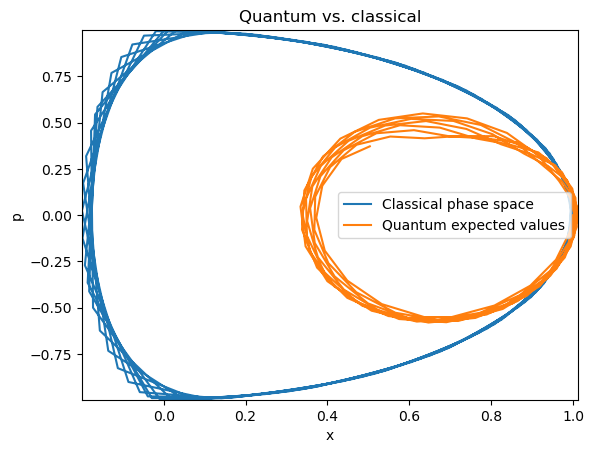

In [86]:
plt.plot(pos[0],vel[0],label='Classical phase space')
plt.plot(result.expect[0],result.expect[1],label='Quantum expected values')
plt.xlim([np.min(pos[0]),np.max(result.expect[0])])
plt.ylim([np.min(vel[0]),np.max(vel[0])])
plt.title('Quantum vs. classical')
plt.xlabel('x')
plt.ylabel('p')
plt.legend()
plt.show()

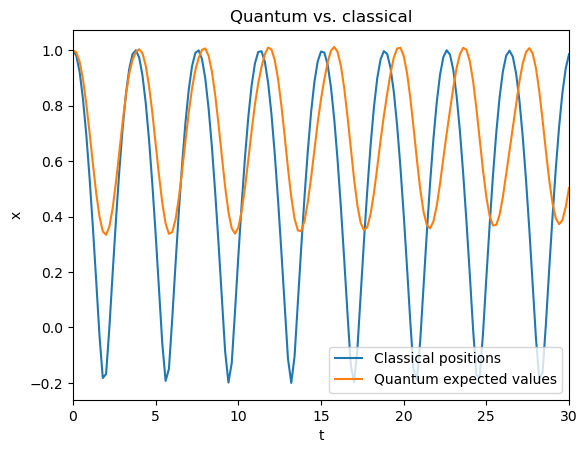

In [87]:
plt.plot(tvec,pos[0],label='Classical positions')
plt.plot(tvec,result.expect[0],label='Quantum expected values')
plt.xlim([0,tf])
plt.title('Quantum vs. classical')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

0-1 Test

Consejo: para que sea más fiable usar pasos de tiempo relativamente grandes y priorizar simulaciones a tiempos largos (> 2500 s con dt = 0.5) con varios valores de c

In [88]:
def cov(x,y):
    q = np.size(x)
    return (1/q)*np.sum((x-np.mean(x))*(y-np.mean(y)))

In [89]:
def chaos_test(O):
    
    N = np.size(O)
    N_0 = int(N/10)
    x = np.linspace(1,N,N)
    t = np.linspace(1,N_0,N_0)
    c = np.linspace(0.1,np.pi/2-0.1,5)
    K = np.zeros(np.size(c))
    E = np.mean(O)
    sigma = 0
    noise = np.random.choice(np.linspace(-0.5,0.5,N), size = N_0)
    
    for i in tqdm(range(np.size(c))):
    
        p = np.zeros(2*N)
        q = np.zeros(2*N)
        M = np.zeros(N_0)
        V = np.zeros(N_0)
        
        for n in range(1,N):
            p[n] = p[n-1] + O[n]*np.cos(c[i]*n)
            q[n] = q[n-1] + O[n]*np.sin(c[i]*n)
       
        for n in range(1,N_0):
            V[n] = E**2*((1-np.cos(n*c[i]))/(1-np.cos(c[i])))
            aux = np.zeros(N-N_0)
            for j in range(1,N-N_0):
                aux[j] = (p[n+j]-p[j])**2+(q[n+j]-q[j])**2
            M[n] = np.mean(aux)+sigma*noise[n]
        
        D = M-V
        K[i] = cov(t,D)/np.sqrt(cov(t,t)*cov(D,D))
    #plt.plot(c,K,'.')
    
    return np.median(K)

In [90]:
r = np.zeros(np.size(w))
for i in range(np.size(w)):
    r[i] = chaos_test(pos[i])
    print(r[i])

100%|██████████| 5/5 [00:00<00:00, 83.21it/s]

0.3247807103320667


In [91]:
chaos_test(np.abs(O))

100%|██████████| 5/5 [00:00<00:00, 118.48it/s]


0.18573464717402977

C:\Users\rodri\AppData\Local\Temp\ipykernel_25464\448336455.py:3: UserWarning: Attempting to set identical left == right == 1 results in singular transformations; automatically expanding.
  plt.xlim([np.min(w),np.max(w)])


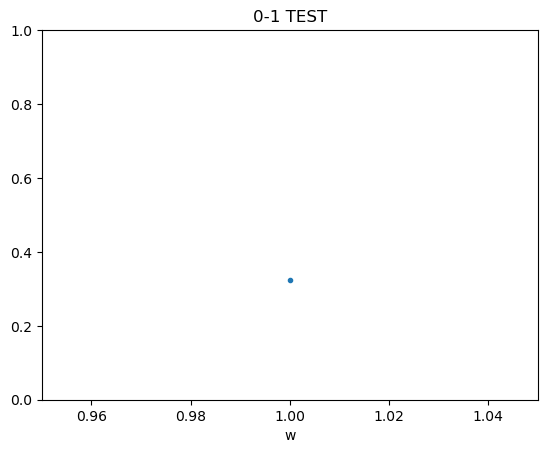

In [92]:
plt.plot(w,r,'.')
plt.ylim([0,1])
plt.xlim([np.min(w),np.max(w)])
plt.title('0-1 TEST')
plt.xlabel('w')
plt.show()

In [93]:
'''
# EXAMEN PARA COMPROBAR QUE EL TEST 0-1 FUNCIONA #

cha = np.zeros([1000,25])
cha[0] = 0.5
coef = np.linspace(3.5,3.7,25)
for m in range(25):
    for n in range(1,1000):
        cha[n,m] = coef[m]*cha[n-1,m]*(1-cha[n-1,m])

r = np.zeros(25)
for i in tqdm(range(25)):
    r[i] = chaos_test(cha[:,i])

plt.plot(coef,r,'.')
plt.ylim([0,1])
'''

"\n# EXAMEN PARA COMPROBAR QUE EL TEST 0-1 FUNCIONA #\n\ncha = np.zeros([1000,25])\ncha[0] = 0.5\ncoef = np.linspace(3.5,3.7,25)\nfor m in range(25):\n    for n in range(1,1000):\n        cha[n,m] = coef[m]*cha[n-1,m]*(1-cha[n-1,m])\n\nr = np.zeros(25)\nfor i in tqdm(range(25)):\n    r[i] = chaos_test(cha[:,i])\n\nplt.plot(coef,r,'.')\nplt.ylim([0,1])\n"

Wigner function evolution

In [94]:
Wigner = []
for i in tqdm(range(np.size(tvec))):   
    Wigner.append(wigner(result.states[i], x, x))

  1%|          | 1/151 [00:31<1:19:54, 31.96s/it]


KeyboardInterrupt: 

In [ ]:
def update_Wigner(num,Wigner):
    plt.cla()
    wmap = wigner_cmap(Wigner[num])
    nrm = mpl.colors.Normalize(-Wigner[num].max(), Wigner[num].max())
    plt.contourf(x, x, Wigner[num], 100, cmap=wmap)
    plt.xlim([-5,5])
    plt.ylim([-5,5])
    plt.title('Evolución de la función de Wigner (t = '+str(format(tvec[num],'.3f'))+' s)')
    plt.xlabel('x')
    plt.ylabel('p')

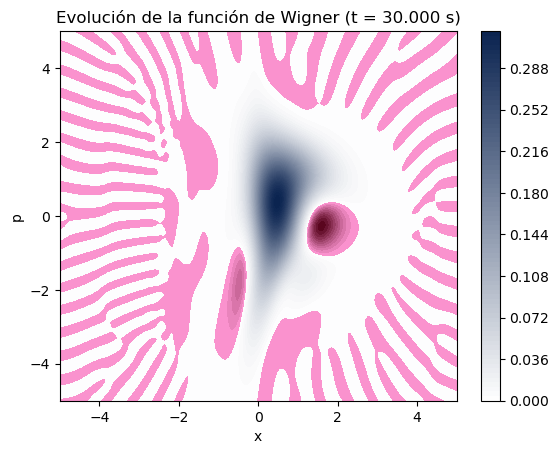

In [ ]:
imW = plt.figure()
wmap = wigner_cmap(Wigner[0])
nrm = mpl.colors.Normalize(-Wigner[0].max(), Wigner[0].max())
figW = plt.contourf(x, x, Wigner[0], 100, cmap=wmap)
plt.colorbar()
animP = animation.FuncAnimation(imW, update_Wigner, int(np.size(tvec)), fargs = (Wigner, ), interval = 10)
animP.save('W3.gif')